In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm import tqdm
import matplotlib.pyplot as plt

from model import KAN

Matplotlib created a temporary cache directory at /tmp/matplotlib-kyno9j92 because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Load MNIST dataset

In [2]:
# Load MNIST dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=64, shuffle=False)

# Define KAN

In [3]:
# Define model
model = KAN(input_features= 28 * 28, output_features=10, layers_hidden=[64])
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define loss
criterion = nn.CrossEntropyLoss()

# Training

In [5]:
# Lists to store training loss and accuracy
train_losses = []
train_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    with tqdm(train_loader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 28 * 28)
            labels = labels

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            accuracy = (output.argmax(dim=1) == labels).float().mean()

            epoch_loss += loss.item()
            epoch_acc += accuracy.item()

            pbar.set_postfix(
                loss=loss.item(),
                accuracy=accuracy.item(),
                lr=optimizer.param_groups[0]["lr"],
            )

        # Calculate average loss and accuracy for the epoch
        avg_loss = epoch_loss / len(train_loader)
        avg_acc = epoch_acc / len(train_loader)

        # Append to lists
        train_losses.append(avg_loss)
        train_accuracies.append(avg_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {avg_acc:.4f}")


100%|██████████| 938/938 [00:22<00:00, 42.29it/s, accuracy=0.938, loss=0.246, lr=0.001] 


Epoch 1/10 - Loss: 0.3511 - Accuracy: 0.8969


100%|██████████| 938/938 [00:22<00:00, 41.47it/s, accuracy=0.938, loss=0.256, lr=0.001] 


Epoch 2/10 - Loss: 0.1759 - Accuracy: 0.9475


100%|██████████| 938/938 [00:22<00:00, 41.57it/s, accuracy=1, loss=0.0473, lr=0.001]    


Epoch 3/10 - Loss: 0.1283 - Accuracy: 0.9606


100%|██████████| 938/938 [00:22<00:00, 41.79it/s, accuracy=0.969, loss=0.0681, lr=0.001]


Epoch 4/10 - Loss: 0.0995 - Accuracy: 0.9694


100%|██████████| 938/938 [00:22<00:00, 41.23it/s, accuracy=1, loss=0.0295, lr=0.001]    


Epoch 5/10 - Loss: 0.0791 - Accuracy: 0.9757


100%|██████████| 938/938 [00:22<00:00, 40.86it/s, accuracy=1, loss=0.00355, lr=0.001]   


Epoch 6/10 - Loss: 0.0637 - Accuracy: 0.9799


100%|██████████| 938/938 [00:22<00:00, 41.47it/s, accuracy=1, loss=0.00379, lr=0.001]   


Epoch 7/10 - Loss: 0.0515 - Accuracy: 0.9836


100%|██████████| 938/938 [00:23<00:00, 40.77it/s, accuracy=0.875, loss=0.211, lr=0.001] 


Epoch 8/10 - Loss: 0.0456 - Accuracy: 0.9853


100%|██████████| 938/938 [00:22<00:00, 42.00it/s, accuracy=1, loss=0.0218, lr=0.001]    


Epoch 9/10 - Loss: 0.0384 - Accuracy: 0.9876


100%|██████████| 938/938 [00:22<00:00, 41.26it/s, accuracy=1, loss=0.00102, lr=0.001]   

Epoch 10/10 - Loss: 0.0336 - Accuracy: 0.9892


# Visualize the Training Accuracy & Loss

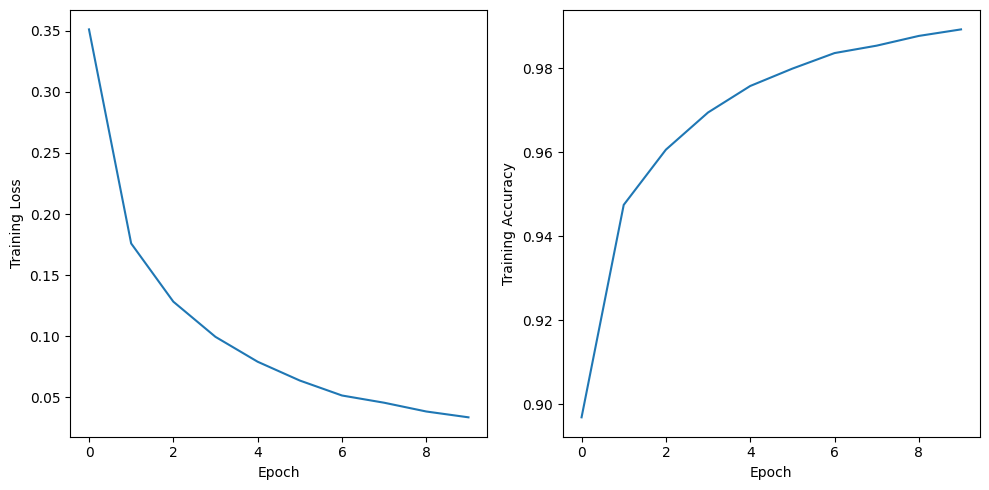

In [6]:
# Plot training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")

plt.tight_layout()
plt.show()

# Validation

In [7]:
for i in range(10):
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28 * 28)
            output = model(images)
            val_loss += criterion(output, labels).item()
            val_accuracy += (output.argmax(dim=1) == labels).float().mean().item()
    val_loss /= len(test_loader)
    val_accuracy /= len(test_loader)

    print(f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

Val Loss: 0.1250411982936425, Val Accuracy: 0.964968152866242
Val Loss: 0.1250411982936425, Val Accuracy: 0.964968152866242
Val Loss: 0.1250411982936425, Val Accuracy: 0.964968152866242
Val Loss: 0.1250411982936425, Val Accuracy: 0.964968152866242
Val Loss: 0.1250411982936425, Val Accuracy: 0.964968152866242
Val Loss: 0.1250411982936425, Val Accuracy: 0.964968152866242
Val Loss: 0.1250411982936425, Val Accuracy: 0.964968152866242
Val Loss: 0.1250411982936425, Val Accuracy: 0.964968152866242
Val Loss: 0.1250411982936425, Val Accuracy: 0.964968152866242
Val Loss: 0.1250411982936425, Val Accuracy: 0.964968152866242
